In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, Dropout, SpatialDropout1D, Bidirectional, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, Sequential
from tensorflow.keras.optimizers import Adam
import keras
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk
import random
import matplotlib.pyplot as plt
import os
import warnings


2023-04-15 17:38:10.680716: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 17:38:11.092482: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-15 17:38:11.272762: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-15 17:38:12.571897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [10]:
# Set a seed for TensorFlow
tf.random.set_seed(12345)

# Set a seed for NumPy
np.random.seed(12345)


In [2]:
warnings.filterwarnings('ignore')  
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


2023-04-15 17:38:21.893570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-15 17:38:21.944550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-15 17:38:21.944809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
cur_dir = os.getcwd() # path to working directory
data_dir = os.path.join(cur_dir, 'data')  


**1.Brief description of the problem and data.**

This task is a Natural Language Processing exercise for twitter sentiment analysis. The challenge involves building a machine learning model that can accurately predict which tweets are about real disasters and which ones aren't. The dataset for the competition contains 10,000 hand-classified tweets.The dataset for the competition contains text that may be considered profane, vulgar, or offensive, thus a part of the task will involve clearing the data. 

In [4]:
train_data = pd.read_csv(os.path.join(data_dir, 'train.csv'),  na_filter=False)
test_data = pd.read_csv(os.path.join(data_dir, 'test.csv'),  na_filter=False)

In [5]:
train_data.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_data.head()

,id,keyword,location,text
0,0,,,Just happened a terrible car crash
1,2,,,"Heard about #earthquake is different cities, s..."
2,3,,,"there is a forest fire at spot pond, geese are..."
3,9,,,Apocalypse lighting. #Spokane #wildfires
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan


These are some of the issues in the training data:
 - Duplicates, probably extracted from retweets
 - Duplicates but with different labels
 - Spelling mistakes which make the model not recognize the same words without additional adjustment
 - Potentioal wrong labels
 I present below some remedy for first two problems. Third issue is unresolved as I tried a few python packages and they did more harm than help. A good NLP pre-trained model for spelling would improve the results significantly. The last issue is also unresolved, but fixing wrong labels should not be part of this exercise. 

In [11]:
x_raw_data = train_data['text']
x_test_data = test_data['text']

In [12]:
y_raw_data = train_data['target']
x_test_ids = list(test_data['id'])

In [13]:
y_raw_data.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

Additionally save the keywords for an extra test I will conduct

In [14]:
x_raw_keyword = train_data['keyword']
x_test_keyword = train_data['keyword']

In [15]:
x_test_data.head()

0                   Just happened a terrible car crash
1    Heard about #earthquake is different cities, s...
2    there is a forest fire at spot pond, geese are...
3             Apocalypse lighting. #Spokane #wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
Name: text, dtype: object

Remove duplicates

In [16]:
import re
def check_for_duplicates(df, df_labels):
    wrong_label_indices = []
    for ix, text in enumerate(df):
        mask = df.str.contains(re.escape(text))
        count = mask.sum()
        if count > 1:
            indices = np.where(mask)[0]
            if df_labels[mask].nunique() > 1:
                wrong_label_indices += list(indices)
    print(f'Number of tweets with wrong labels: {len(wrong_label_indices)}')

    duplicated_mask = df.duplicated(keep=False)
    duplicated_indices = np.where(duplicated_mask)[0]
    print(f'Number of tweets that are duplicates: {duplicated_indices.size}')
    return wrong_label_indices


The results below show that there are a few hundread duplicates with same labels and duplicates with different labels. Latter is a major issue. 

In [17]:
wrong_label_indeces = check_for_duplicates(x_raw_data, y_raw_data)

Number of tweets with wrong labels: 250
Number of tweets that are duplicates: 179


See below that the texts are the same ...

In [18]:
print(x_raw_data.iloc[wrong_label_indeces[0]])
print(x_raw_data.iloc[wrong_label_indeces[1]])

To fight bioterrorism sir.
To fight bioterrorism sir.


... but the labels are different

In [19]:
y_raw_data[[wrong_label_indeces[0],wrong_label_indeces[1]]]

610    1
624    0
Name: target, dtype: int64

Do not bother with fixing wrong labels, instead, remove them

In [20]:
x_raw_data.drop(wrong_label_indeces, inplace=True)
y_raw_data.drop(wrong_label_indeces, inplace=True)

also remove duplicates and keep only the first instance, also remove associated labels and keywords to make all arrays the same size

In [21]:
x_raw_data = x_raw_data.drop_duplicates(keep='first')
y_raw_data = y_raw_data.loc[x_raw_data.index]

In [22]:
x_raw_keyword = x_raw_keyword.loc[x_raw_data.index]

In [23]:
print(x_raw_data.shape)
print(y_raw_data.shape)
print(x_raw_keyword.shape)

(7449,)
(7449,)
(7449,)


In [24]:
x_raw_data = x_raw_data.reset_index(drop=True)
y_raw_data = y_raw_data.reset_index(drop=True)
x_raw_keyword = x_raw_keyword.reset_index(drop=True)

Finally check there is no duplicates or tweets labelled both positive and negative

In [25]:
wrong_label_indeces = check_for_duplicates(x_raw_data, y_raw_data)

Number of tweets with wrong labels: 0
Number of tweets that are duplicates: 0


**2.Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data.**

Below I am conducting standard NLP prepocessing of the texts in addition to the cleaning I have done for this specific dataset. 



In [26]:
def preprocess_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    # Remove HTML tags and non-alphanumeric characters
    tweet = re.sub(r'<[^>]+>|[^A-Za-z0-9 ]+', ' ', tweet)
    # Convert to lowercase
    tweet = tweet.lower()
    # Strip whitespace
    tweet = tweet.strip()
    return tweet

In [27]:
# Load the stopwords
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [29]:
# a function to remove stopwords from a tweet
def remove_stopwords(tweet):
    words = tweet.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [30]:
x_raw_data = x_raw_data.apply(preprocess_tweet)
x_raw_data = x_raw_data.apply(remove_stopwords)

In [31]:
x_raw_data.head()

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    13 000 people receive wildfires evacuation ord...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

In [32]:
x_test_data = x_test_data.apply(preprocess_tweet)
x_test_data = x_test_data.apply(remove_stopwords)

In [33]:
x_test_data.head()

0                          happened terrible car crash
1    heard earthquake different cities stay safe ev...
2    forest fire spot pond geese fleeing across str...
3                apocalypse lighting spokane wildfires
4               typhoon soudelor kills 28 china taiwan
Name: text, dtype: object

The values for labels are either 0 or 1, thus it is case of binary classification

(array([4275.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3174.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

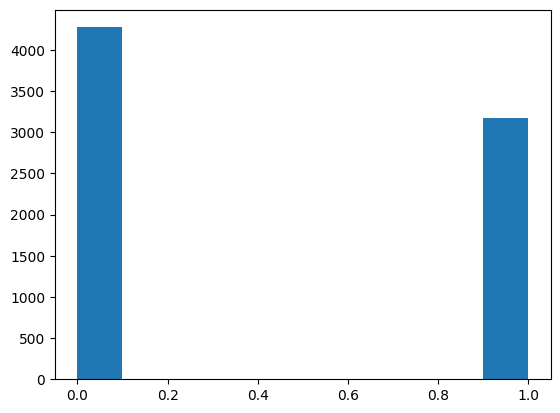

In [34]:
plt.hist(y_raw_data)

In [35]:
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sabuhi_khalili/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Finally, we need to lemmatize and tokenize. To associate each word with correct tag helps improve the lemmatization process. I am using whole sentence to define the tag so that the same word which can be noun and verb at the same time is properly identified.

In [35]:
import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()


tag_map = { "J": wordnet.ADJ,
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV}
def get_wordnet_pos(tag):
    return tag_map.get(tag[0], wordnet.NOUN)

def lemmatize_text(sentence):
    tokens = word_tokenize(sentence)
    # get the part of speech for each token using NLTK's pos_tag function
    tagged_tokens = nltk.pos_tag(tokens)
    # lemmatize the tokens using WordNetLemmatizer and the correct part of speech tag
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos=get_wordnet_pos(tag)) for token, tag in tagged_tokens]
    return ' '.join(lemmatized_tokens)
text = "I saw three dogs running in the park"
lemmatized_text = lemmatize_text(text)
print(lemmatized_text)

text = "I decided to walk in the strets"
lemmatized_text = lemmatize_text(text)
print(lemmatized_text)

I saw three dog run in the park
I decide to walk in the strets


In [36]:
x_raw_data = x_raw_data.apply(lemmatize_text)
x_test_data = x_test_data.apply(lemmatize_text)

In [37]:
x_raw_data.head()

0           deed reason earthquake may allah forgive u
1                forest fire near la ronge sask canada
2    resident ask shelter place notify officer evac...
3    13 000 people receive wildfire evacuation orde...
4    get sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

In [38]:
x_test_data.head()

0                            happen terrible car crash
1    heard earthquake different city stay safe ever...
2    forest fire spot pond geese flee across street...
3                    apocalypse light spokane wildfire
4                typhoon soudelor kill 28 china taiwan
Name: text, dtype: object

Below you will see that total character in each text is no greater than 140, which is the limit for tweets in the past. 

(array([ 23.,  49.,  70.,  97., 160., 194., 224., 176., 301., 305., 294.,
        335., 371., 404., 286., 409., 453., 309., 452., 439., 405., 292.,
        376., 279., 261., 130., 158.,  69.,  37.,  37.,  18.,  18.,   5.,
          6.,   6.,   1.]),
 array([  3.        ,   6.72222222,  10.44444444,  14.16666667,
         17.88888889,  21.61111111,  25.33333333,  29.05555556,
         32.77777778,  36.5       ,  40.22222222,  43.94444444,
         47.66666667,  51.38888889,  55.11111111,  58.83333333,
         62.55555556,  66.27777778,  70.        ,  73.72222222,
         77.44444444,  81.16666667,  84.88888889,  88.61111111,
         92.33333333,  96.05555556,  99.77777778, 103.5       ,
        107.22222222, 110.94444444, 114.66666667, 118.38888889,
        122.11111111, 125.83333333, 129.55555556, 133.27777778,
        137.        ]),
 <BarContainer object of 36 artists>)

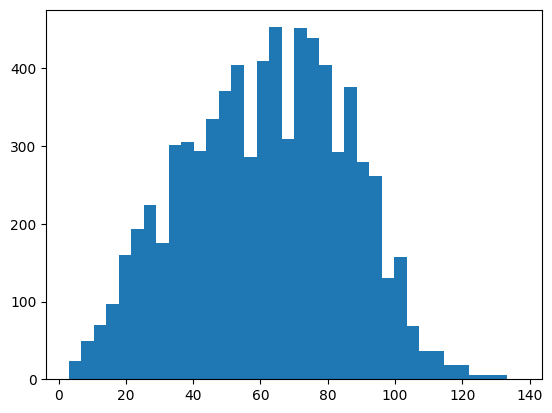

In [39]:
plt.figure()
plt.hist(x_raw_data.str.len(), bins='auto')

(array([  7.,  19.,  44.,  78.,  85., 110., 104., 158., 159., 186., 209.,
        220., 204., 193., 254., 221., 244., 225., 186., 171.,  69.,  47.,
         38.,  24.,   3.,   2.,   3.]),
 array([  0.        ,   4.85185185,   9.7037037 ,  14.55555556,
         19.40740741,  24.25925926,  29.11111111,  33.96296296,
         38.81481481,  43.66666667,  48.51851852,  53.37037037,
         58.22222222,  63.07407407,  67.92592593,  72.77777778,
         77.62962963,  82.48148148,  87.33333333,  92.18518519,
         97.03703704, 101.88888889, 106.74074074, 111.59259259,
        116.44444444, 121.2962963 , 126.14814815, 131.        ]),
 <BarContainer object of 27 artists>)

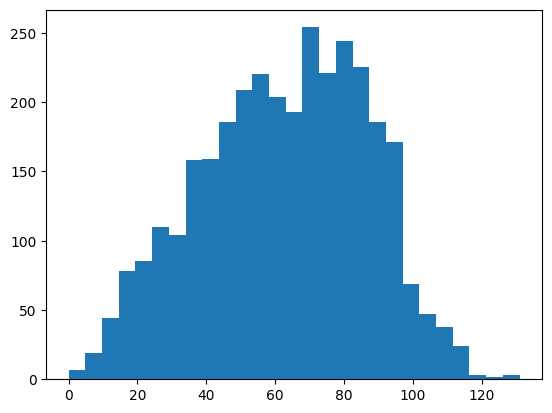

In [40]:
plt.figure()
plt.hist(x_test_data.str.len(), bins='auto')

The final stage in data processing is the tokenizer and I use combined data to define tokens for words so that no words are left out

In [41]:
# Create a tokenizer 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(x_raw_data)+list(x_test_data))


In [42]:
def tokenize_data(tokenizer, df, max_len=None):
    # Convert the texts to sequences of token IDs
    df_seq = tokenizer.texts_to_sequences(df)
    if max_len is None:
        max_len = max(len(seq) for seq in df_seq)

    # Pad the sequences with zeros to a fixed length of 140
    df_padded = pad_sequences(df_seq, maxlen=max_len, padding='post', truncating='post')
    return df_padded, max_len

In [43]:
x_data_vetorized, max_len = tokenize_data(tokenizer=tokenizer, df=x_raw_data)
x_data_vetorized.shape

(7449, 27)

In [44]:
x_test_vetorized, m= tokenize_data(tokenizer=tokenizer, df=x_test_data, max_len=max_len)
x_test_vetorized.shape

(3263, 27)

See below the same word has the same token in both train and test data, check the word 'wildfire'

In [46]:
x_raw_data[3]

'13 000 people receive wildfire evacuation order california'

In [47]:
x_test_data[3]

'apocalypse light spokane wildfire'

In [48]:
x_data_vetorized[3,:]

array([ 595, 2433,   13, 1795,  105,  250,  316,   53,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [49]:
x_test_vetorized[3,:]

array([ 322,  262, 5016,  105,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [50]:
vocab_size = len(tokenizer.word_index)
print(vocab_size)

18622


In [51]:
x_keyword_vectorized, m= tokenize_data(tokenizer=tokenizer, df=x_raw_keyword, max_len=1)
x_keyword_test_vectorized, m= tokenize_data(tokenizer=tokenizer, df=x_test_keyword, max_len=1)

In [52]:
def train_valid_split(data: np.ndarray, labels: np.ndarray, train_pct:float=0.8):
    N = data.shape[0]  
    train_indices = np.random.choice(N, int(N*train_pct), replace=False)
    train_data = data[train_indices,:]
    train_labels = labels[train_indices]

    valid_indices = np.setdiff1d(np.arange(N), train_indices)
    valid_data = data[valid_indices,:]   
    valid_labels = labels[valid_indices]
    return train_data, train_labels, valid_data, valid_labels, train_indices, valid_indices


Instead of using tensorflow, we do train vs validation split here. In this way, we can generate data and save them, then use it in all models instead of having tensorflow doing the split each time. 

In [53]:
x_train, y_train, x_valid, y_valid, train_indices, valid_indices = train_valid_split(data=x_data_vetorized, labels=y_raw_data, train_pct=0.8)

In [54]:
x_train_keyword = x_keyword_vectorized[train_indices]
x_valid_keyword = x_keyword_vectorized[valid_indices]

In [55]:
print(x_train.shape)
print(x_valid.shape)

(5959, 27)
(1490, 27)


**3.Model Architecture + 4. Results and Analysis**

Below is a standard LSTM network for binary classification. I will start with shallow model, then gradually activate additional layers. The model uses bidirectional lstm layer and 2 Dense block for classification. The loss function is binary_cross_entropy with accuracy metrics, the optimizer is set to ADAM. A similiar work is done by https://www.analyticsvidhya.com/blog/2022/01/sentiment-analysis-with-lstm/ and I use it as a starting point

In [57]:
embedding_dim = 50

In [59]:
model = keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    Bidirectional(keras.layers.LSTM(64)),
    Dense(27, activation='relu'),
    Dense(1, activation='sigmoid')
])
# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 27, 50)            931100    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              58880     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 27)                3483      
                                                                 
 dense_3 (Dense)             (None, 1)                 28        
                                                                 
Total params: 993,491
Trainable params: 993,491
Non-trainable params: 0
_________________________________________________________________


In [60]:
history = model.fit(x_train, y_train, 
                    epochs=10, batch_size=64, verbose=False, 
                    validation_data=(x_valid, y_valid))


2023-04-15 18:06:55.586842: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-04-15 18:06:57.250004: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [61]:
history.history
model.save('my_model_1.h5')

In [62]:
def plot_metrics(history):
    epochs = range(1, len(history['accuracy']) + 1)

    plt.plot(epochs, history['accuracy'], '--b', label='Training accuracy')
    plt.plot(epochs, history['val_accuracy'], '--r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    # Plot training and validation loss
    plt.plot(epochs, history['loss'], '--b', label='Training loss')
    plt.plot(epochs, history['val_loss'], '--r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()



Below we may see that training data quickly overfits while the model cannot generalize the training for validation data. However, first epoch validation data results are at around 82 percent accuracy, which is high given the other results in Kaggle. The decreasing pattern of validation accuracy afte each epoch will be visible in most of the models. One possible cause of this pattern could be there are many short tweets with similiar text but used both for disaster and non-disaster tweets, thus peventing the model to establish systematic relationship between tweets and labels. Another reason could be related to wrong labels, which requires manual work to go through. 

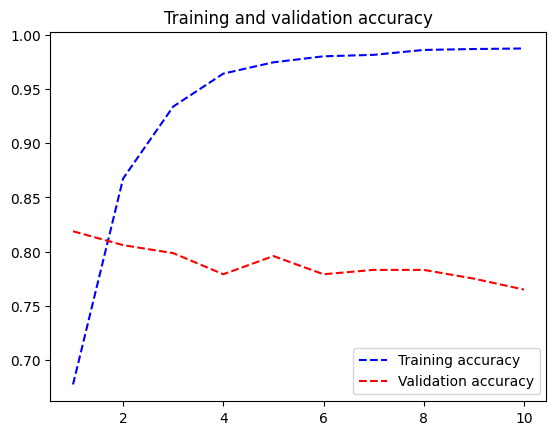

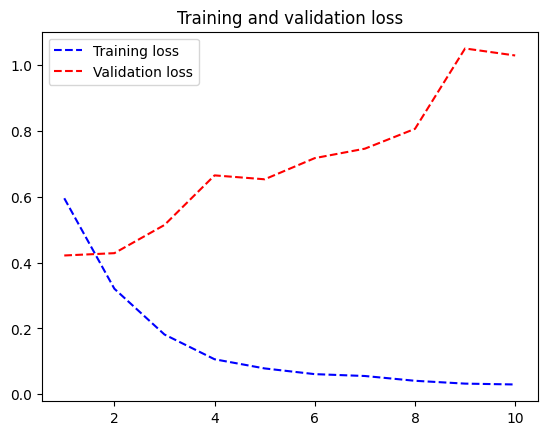

In [63]:
plot_metrics(history.history)

The setup below allows for dropouts, more layers and additional regularizers. I am using GRU below, but LSTM results are vevy similiar. 

In [64]:

def create_gru_model(max_sequence_length, max_vocab_size, embedding_dim, num_layers=1, num_units=64, l2_rate=0.001, dropout_rate=0.0, embedding_layer=None):
    # Input layer
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=max_sequence_length))
    if embedding_layer is None:
        model.add(tf.keras.layers.Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    else:
        model.add(embedding_layer)
    model.add(tf.keras.layers.SpatialDropout1D(rate=dropout_rate))
    
    for i in range(num_layers):
        if i == num_layers - 1:
            # Last layer
            if l2_rate is not None:
                model.add(tf.keras.layers.GRU(units=num_units, kernel_regularizer=regularizers.l2(l2_rate)))
            else:
                model.add(Bidirectional(tf.keras.layers.GRU(units=num_units)))
        else:
            if l2_rate is not None:
                model.add(tf.keras.layers.GRU(units=num_units, kernel_regularizer=regularizers.l2(l2_rate), return_sequences=True))
            else:
                model.add(Bidirectional(tf.keras.layers.GRU(units=num_units, return_sequences=True)))
    
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    return model

In [166]:

def create_lstm_model(max_sequence_length, max_vocab_size, embedding_dim, num_layers=1, num_units=64, l2_rate=0.001, dropout_rate=0.0, embedding_layer=None):
    # Input layer
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=max_sequence_length))
    if embedding_layer is None:
        model.add(tf.keras.layers.Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    else:
        model.add(embedding_layer)
    model.add(tf.keras.layers.SpatialDropout1D(rate=dropout_rate))
    
    for i in range(num_layers):
        if i == num_layers - 1:
            # Last layer
            if l2_rate is not None:
                model.add(tf.keras.layers.LSTM(units=num_units, kernel_regularizer=regularizers.l2(l2_rate)))
            else:
                model.add(Bidirectional(tf.keras.layers.LSTM(units=num_units)))
        else:
            if l2_rate is not None:
                model.add(tf.keras.layers.LSTM(units=num_units, kernel_regularizer=regularizers.l2(l2_rate), return_sequences=True))
            else:
                model.add(Bidirectional(tf.keras.layers.LSTM(units=num_units, return_sequences=True)))
    
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    return model

I use below spatial dropout for embedded layer with 50% dropout, keep the number of layers at 1 and no kernel regularizer

In [66]:
model = create_gru_model(max_sequence_length=max_len, max_vocab_size=vocab_size, embedding_dim=50, num_layers=1, dropout_rate=0.5, l2_rate=None)
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 27, 50)            931100    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 27, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              44544     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 975,773
Trainable params: 975,773
Non-trainable params: 0
_________________________________________________________________


In [67]:
history = model.fit(x_train, y_train, 
                    epochs=10, batch_size=64, verbose=False, 
                    validation_data=(x_valid, y_valid))

In [68]:
history.history
model.save('my_model_2.h5')

Dropout makes the model improve on training data more gradually, but the results still diverge after around 5 epochs. Overall, this feature does little on improving model prediction performance

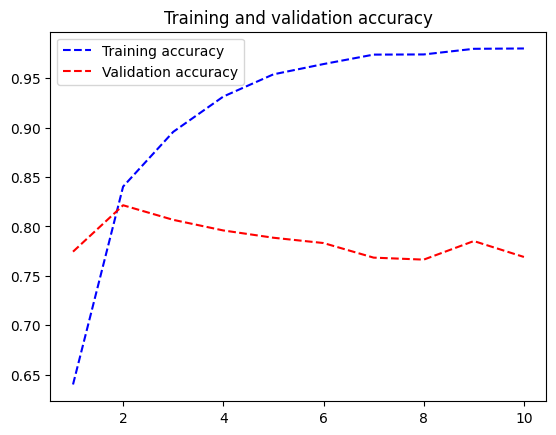

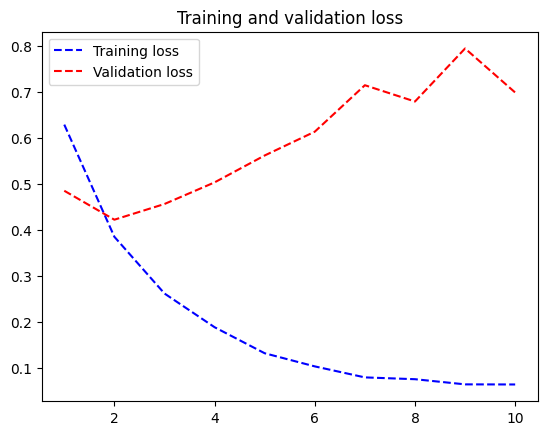

In [69]:
plot_metrics(history.history)

Layers have been increased to 3

In [70]:
model = create_gru_model(max_sequence_length=max_len, max_vocab_size=vocab_size, embedding_dim=50, num_layers=3, dropout_rate=0.5, l2_rate=None)
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 27, 50)            931100    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 27, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_6 (Bidirectio  (None, 27, 128)          44544     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 27, 128)          74496     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              74496     
 nal)                                                 

In [71]:
history = model.fit(x_train, y_train, 
                    epochs=10, batch_size=64, verbose=False, 
                    validation_data=(x_valid, y_valid))

In [72]:
history.history
model.save('my_model_3.h5')

Validation accruacy is more stable, but did not perform better than the other model

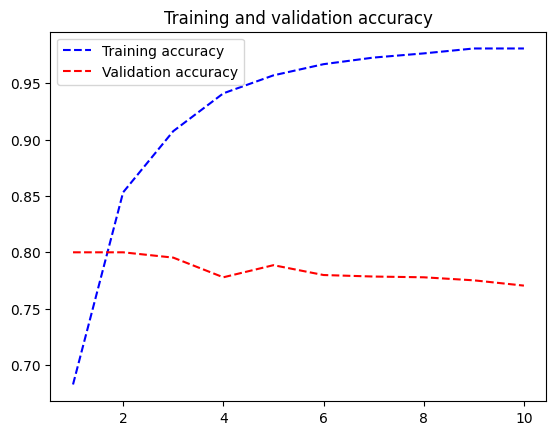

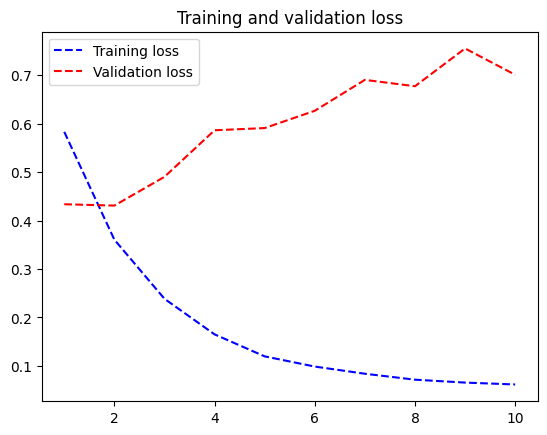

In [73]:
plot_metrics(history.history)

I introduce here kernel regularizer, if I set l2_rate to a value as 0.01 making it very restrictive, the model does not learn and is stuck at a  local maxima with a low accuracy. After testing a few values by relaxing the value, I figure out the additional benefit of l2 regularizer is little to no existent. 

In [90]:
model = create_gru_model(max_sequence_length=max_len, max_vocab_size=vocab_size, embedding_dim=50, num_layers=3, dropout_rate=0.5, l2_rate=0.0007)
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 27, 50)            931100    
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 27, 50)           0         
 lDropout1D)                                                     
                                                                 
 gru_19 (GRU)                (None, 27, 64)            22272     
                                                                 
 gru_20 (GRU)                (None, 27, 64)            24960     
                                                                 
 gru_21 (GRU)                (None, 64)                24960     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                      

In [91]:
history = model.fit(x_train, y_train, 
                    epochs=10, batch_size=64, verbose=False, 
                    validation_data=(x_valid, y_valid))

In [92]:
history.history
model.save('my_model_4.h5')

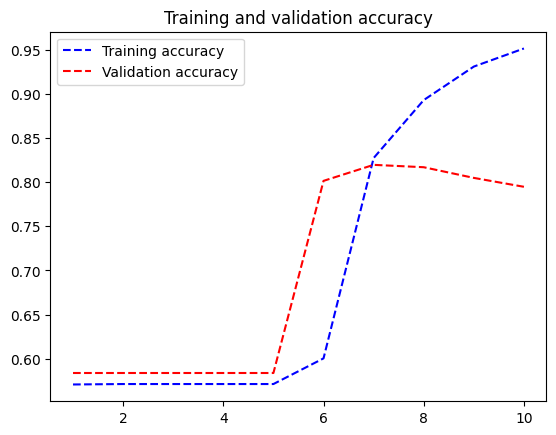

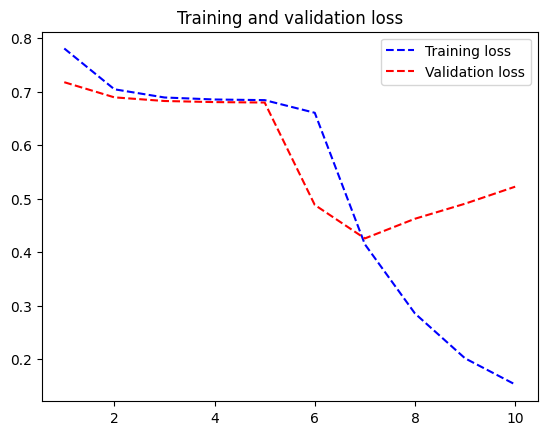

In [93]:
plot_metrics(history.history)

Here I do a little detour. Here I use a pretrained model to set up embedding layer. This idea is taken from (https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial), the rest of the model is the same with the models above except I am not using  l2 regularizer. 

In [94]:
import gensim

In [95]:
documents = [_text.split() for _text in list(x_raw_data)+list(x_test_data)] 


In [96]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=max_len)

In [97]:
w2v_model.build_vocab(documents)

In [98]:
words = list(w2v_model.wv.key_to_index.keys())
vocab_size_w = len(words)
print("Vocab size", vocab_size_w)

Vocab size 3211


In [99]:
w2v_model.train(documents, total_examples=len(documents), epochs=10)

(783566, 1019280)

Unfortunately, it is visible from below that the gensim can establish association with seemingly unrelated words as well. However, some fo them are not totally random. For example, wildfire has similiarity with northen california in this context seems some of the tweets were reporting wildfires in that area.

In [101]:
w2v_model.wv.most_similar("wildfire")

[('northern', 0.98179030418396),
 ('california', 0.9693616032600403),
 ('raze', 0.9684868454933167),
 ('governor', 0.9540603160858154),
 ('home', 0.9477320313453674),
 ('abc', 0.9473885893821716),
 ('late', 0.9441699981689453),
 ('rocky', 0.9300314784049988),
 ('advance', 0.9134551882743835),
 ('catch', 0.908627450466156)]

In [102]:
embedding_matrix = np.zeros((vocab_size, max_len))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(18622, 27)


In [130]:
embedding_layer = Embedding(vocab_size, max_len, weights=[embedding_matrix], input_length=max_len, trainable=False)
model = create_gru_model(max_sequence_length=max_len, max_vocab_size=vocab_size, embedding_dim=embedding_dim, num_layers=3, dropout_rate=0.5, l2_rate=None, embedding_layer=embedding_layer)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 27, 27)            502794    
                                                                 
 spatial_dropout1d_13 (Spati  (None, 27, 27)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_24 (Bidirecti  (None, 27, 128)          35712     
 onal)                                                           
                                                                 
 bidirectional_25 (Bidirecti  (None, 27, 128)          74496     
 onal)                                                           
                                                                 
 bidirectional_26 (Bidirecti  (None, 128)              74496     
 onal)                                               

The model is learning very slowly so I increased the epoch for this run

In [131]:
model.fit(x_train, y_train, epochs = 50, batch_size=64, verbose = False, shuffle=False, validation_data=(x_valid, y_valid))

In [132]:
model.history.history
model.save('my_model_5.h5')

The major change with this addition is that the training and validation accuracy improves in a similiar way until certain epoch, however, the peak performance we get from this setup is much worse to any model above. Overall, reducing the vocabulary size for the model to train this way might improve how the model works, but we need a better tool than gensim for this task. 

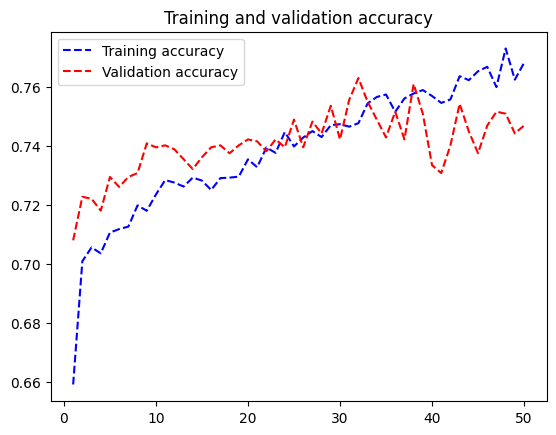

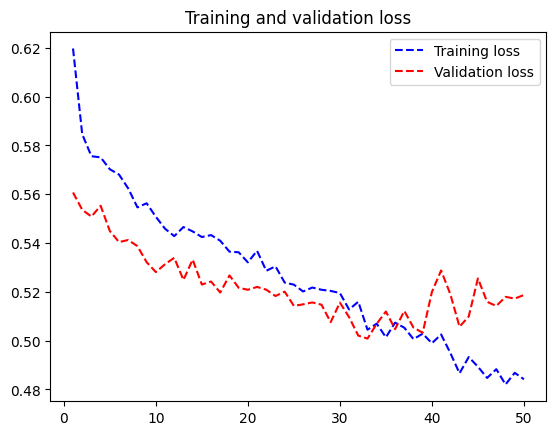

In [133]:
plot_metrics(model.history.history)

The last setup is to check whether the model would perform better if we incorporated keywords to overall setup. I define a Dense layer for keywords to associate them with labels and combine two models under single model. 

In [134]:

def combined_model(max_sequence_length, max_vocab_size, embedding_dim, num_layers=1, num_units=64, dropout_rate=0.0):
    # Input layer
    text_input = tf.keras.layers.Input(shape=(max_sequence_length,), name='text_input')
    keyword_input = tf.keras.layers.Input(shape=(1,), name='keyword_input')

    text_model = tf.keras.Sequential()
    text_model.add(text_input)
    text_model.add(tf.keras.layers.Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    text_model.add(tf.keras.layers.SpatialDropout1D(rate=dropout_rate))
    
    for i in range(num_layers):
        if i == num_layers - 1:
            # Last layer
            text_model.add(Bidirectional(tf.keras.layers.GRU(units=num_units)))
        else:
            text_model.add(Bidirectional(tf.keras.layers.GRU(units=num_units, return_sequences=True)))
    
    keyword_model =  tf.keras.Sequential()
    keyword_model.add(keyword_input)
    keyword_model.add(Dense(units=num_units))

    concat_layer = tf.keras.layers.concatenate([text_model.output, keyword_model.output])
    output_layer = Dense(units=1, activation='sigmoid')(concat_layer)

    model = tf.keras.Model(inputs=[text_input, keyword_input], outputs=output_layer)
    
    return model

In [138]:
comb_model = combined_model(max_sequence_length=max_len, max_vocab_size=vocab_size, embedding_dim=50, num_layers=3, dropout_rate=0.5)
optimizer = Adam(learning_rate=0.001)
comb_model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
comb_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 27)]         0           []                               
                                                                                                  
 embedding_17 (Embedding)       (None, 27, 50)       931100      ['text_input[0][0]']             
                                                                                                  
 spatial_dropout1d_15 (SpatialD  (None, 27, 50)      0           ['embedding_17[0][0]']           
 ropout1D)                                                                                        
                                                                                                  
 bidirectional_30 (Bidirectiona  (None, 27, 128)     44544       ['spatial_dropout1d_15[0][0

In [140]:
comb_model.fit(x={'text_input': x_train, 'keyword_input': x_train_keyword}, y=y_train, epochs = 20, batch_size=64, verbose = False, shuffle=False, validation_data=({'text_input': x_valid, 'keyword_input': x_valid_keyword}, y_valid))

The results are not much different from the earlier models. 

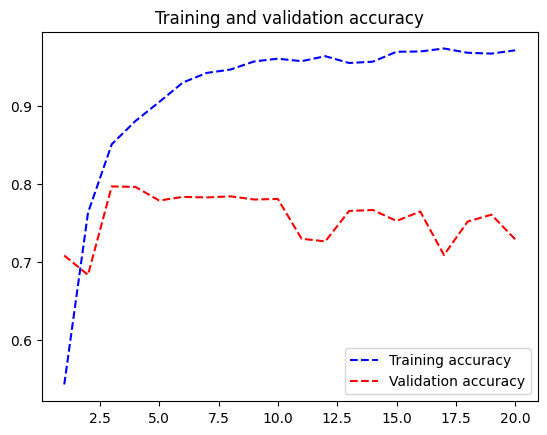

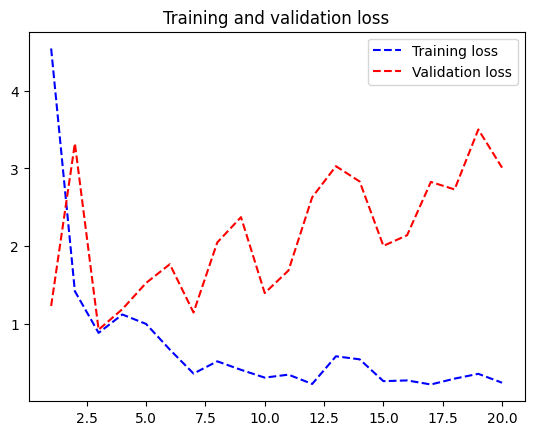

In [141]:
plot_metrics(comb_model.history.history)

**5.Conclusion**

To sum up, we solved the issues with duplicates and partially solved tweets with wrong labels, but the results would improve if following issues are resolved in data part:
 - correcting spelling mistakes
 - improving lemmatization/tokenization process. This is related to spelling as well to a certain extent. Wildfire and wild-fire are recognized as two different word and tokenized as two different words. In addition to spelling mistakes, lemmatization also cannot convert past simple to root form for irregular verbs despite using verb tag. More work could be done on this. 
The results would improve much better if we used already pre-trained model for text analysis and train it to differentiate for this task with this data. But that is out of scope of this exercise. 

I will use model 3 setup to predict the test data. I increase embedding dimension to 200 (after a few iterations) to improve the peak result slightly which is achieved at the first epoch. Overall, I tried with different embedding in the other models, the change was mostly on the peak result achieved not in convergence patterns.

In [172]:
model = create_gru_model(max_sequence_length=max_len, max_vocab_size=vocab_size, embedding_dim=200, num_layers=3, dropout_rate=0.5, l2_rate=None)
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 27, 200)           3724400   
                                                                 
 spatial_dropout1d_27 (Spati  (None, 27, 200)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_66 (Bidirecti  (None, 27, 128)          102144    
 onal)                                                           
                                                                 
 bidirectional_67 (Bidirecti  (None, 27, 128)          74496     
 onal)                                                           
                                                                 
 bidirectional_68 (Bidirecti  (None, 128)              74496     
 onal)                                               

In [173]:
model.fit(x_train, y_train, epochs = 1, batch_size=64, verbose = 1, shuffle=False, validation_data=(x_valid, y_valid))

94/94 [==============================] - 7s 37ms/step - loss: 0.5448 - accuracy: 0.7211 - val_loss: 0.4237 - val_accuracy: 0.8188


In [174]:
model = create_lstm_model(max_sequence_length=max_len, max_vocab_size=vocab_size, embedding_dim=200, num_layers=3, dropout_rate=0.5, l2_rate=None)
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 27, 200)           3724400   
                                                                 
 spatial_dropout1d_28 (Spati  (None, 27, 200)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_69 (Bidirecti  (None, 27, 128)          135680    
 onal)                                                           
                                                                 
 bidirectional_70 (Bidirecti  (None, 27, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_71 (Bidirecti  (None, 128)              98816     
 onal)                                               

In [175]:
model.fit(x_train, y_train, epochs = 1, batch_size=64, verbose = 1, shuffle=False, validation_data=(x_valid, y_valid))

94/94 [==============================] - 8s 41ms/step - loss: 0.5767 - accuracy: 0.6939 - val_loss: 0.4289 - val_accuracy: 0.8181


In [176]:
y_test_pred = model.predict(x_test_vetorized)

102/102 [==============================] - 2s 13ms/step


In [177]:
y_test_pred = np.where(y_test_pred > 0.5, 1, 0)

df = pd.DataFrame(data=y_test_pred, index=test_data['id'], columns=['target'])


In [178]:
df.head()

,target
id,
0,1
2,1
3,1
9,1
11,1


In [179]:
df.to_csv(os.path.join(data_dir, 'test_labels.csv'))

Results below show that the prediction accuracy of the main model with GRU and LSTM (first one). I couldn't manage to pass 80 percent altough validation dataset were performing better than 80 percent, but overall it is quite close and results are fine. Top performer excluding 100% hackers is 86%.  

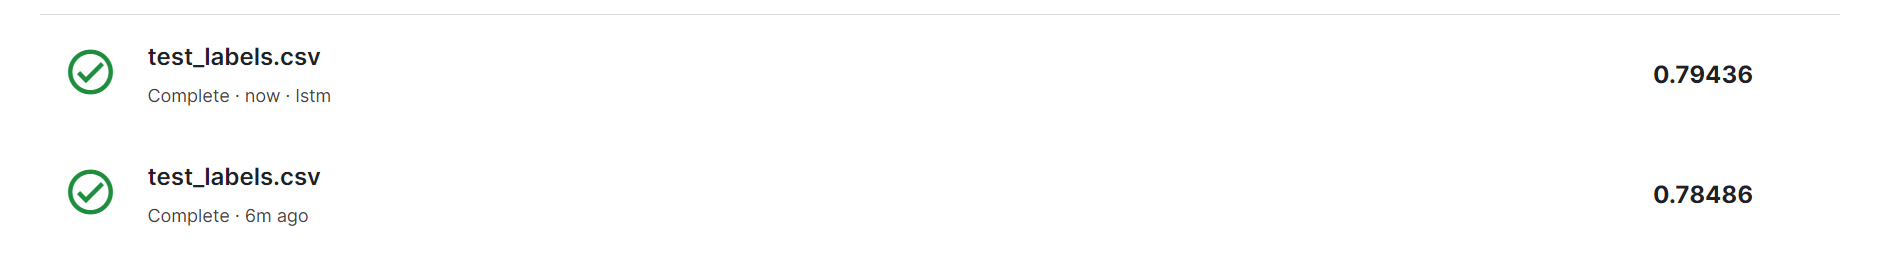

In [181]:
from IPython.display import Image
Image(filename=os.path.join(data_dir,'results.png'))

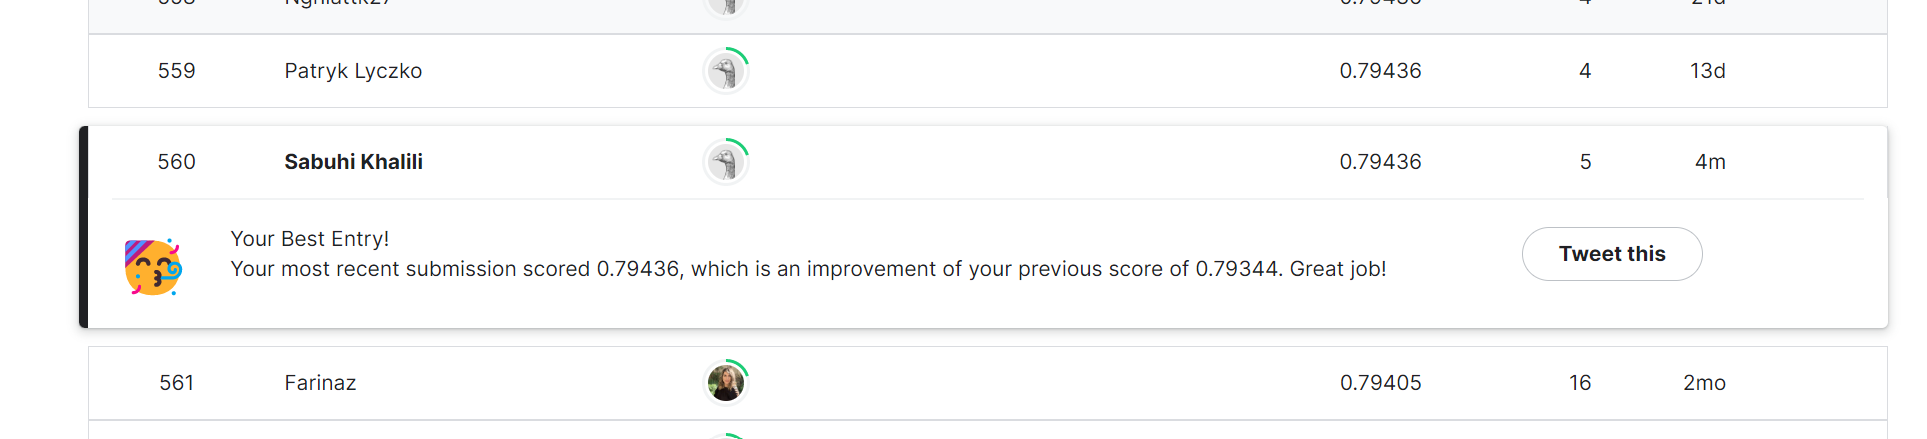

In [182]:
from IPython.display import Image
Image(filename=os.path.join(data_dir,'results_lead.png'))

References:

Sentiment Analysis with LSTM - Koushiki Dasgupta Chaudhuri  https://www.analyticsvidhya.com/blog/2022/01/sentiment-analysis-with-lstm/ 

Gensim Word2Vec Tutorial - Pierre Megret, https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial
